In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

import gurobipy as gp
from gurobipy import GRB, Model
import math

import warnings
warnings.filterwarnings('ignore')

# LQ45

In [2]:
df_lq45 = pd.read_csv("data_historis_jakarta_stock_exchange_lq45.csv")
df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [3]:
# replace commas & convert to float
columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in columns:
    df_lq45[col] = df_lq45[col].str.replace('.', '').str.replace(',', '.').astype(float)

In [4]:
df_lq45 = df_lq45.sort_values(by='Tanggal').reset_index(drop=True)
df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,1011.62,1017.16,1017.52,1007.50,"612,73M","-0,28%"
1,2020-01-03,1021.49,1016.72,1021.49,1012.97,"1,08B","0,98%"
2,2020-01-06,1010.23,1012.93,1016.16,1005.83,"1,12B","-1,10%"
3,2020-01-07,1014.64,1013.78,1016.53,1008.49,"1,19B","0,44%"
4,2020-01-08,1005.45,1007.10,1010.44,1004.10,"1,37B","-0,91%"
...,...,...,...,...,...,...,...
1144,2024-09-20,973.20,979.44,981.16,971.35,"14,75B","-0,66%"
1145,2024-09-23,985.26,973.10,985.26,972.10,"7,25B","1,24%"
1146,2024-09-24,985.41,984.91,988.27,983.06,"5,49B","0,02%"
1147,2024-09-25,977.15,979.45,980.72,958.70,"14,28B","-0,84%"


In [5]:
start_date = pd.Timestamp('2022-12-31')
end_date = pd.Timestamp('2023-12-31')

df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%Y-%m-%d')
filtered_df_lq45 = df_lq45[(df_lq45['Tanggal'] >= start_date) & (df_lq45['Tanggal'] <= end_date)]
filtered_df_lq45 = filtered_df_lq45.reset_index(drop=True)

In [6]:
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,"1,54B","-0,22%"
1,2023-01-03,940.46,935.08,945.03,931.78,"3,86B","0,57%"
2,2023-01-04,928.53,940.46,941.88,928.53,"3,28B","-1,27%"
3,2023-01-05,909.66,928.54,928.57,902.98,"3,94B","-2,03%"
4,2023-01-06,913.02,909.65,913.98,899.61,"2,19B","0,37%"
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,"2,56B","0,33%"
236,2023-12-26,967.36,967.68,969.99,964.74,NaN,"0,00%"
237,2023-12-27,968.73,971.35,973.96,967.90,"2,88B","0,14%"
238,2023-12-28,977.07,973.18,979.40,971.76,"2,79B","0,86%"


In [7]:
# convert 'Perubahan%' to float
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.replace(",", ".")
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.rstrip('%').astype(float)

In [8]:
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,"1,54B",-0.22
1,2023-01-03,940.46,935.08,945.03,931.78,"3,86B",0.57
2,2023-01-04,928.53,940.46,941.88,928.53,"3,28B",-1.27
3,2023-01-05,909.66,928.54,928.57,902.98,"3,94B",-2.03
4,2023-01-06,913.02,909.65,913.98,899.61,"2,19B",0.37
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,"2,56B",0.33
236,2023-12-26,967.36,967.68,969.99,964.74,NaN,0.00
237,2023-12-27,968.73,971.35,973.96,967.90,"2,88B",0.14
238,2023-12-28,977.07,973.18,979.40,971.76,"2,79B",0.86


In [9]:
def convert_number(s):
    if isinstance(s, str):
        s = s.replace(",", ".")
        if 'M' in s:
            return float(s.replace("M", "")) * 1e6
        elif 'B' in s:
            return float(s.replace("B", "")) * 1e9
        else:
            return float(s)
    else:
        return s

# a = "612,73M"
# b = "14,75B"

# print(convert_number(a))
# print(convert_number(b))

In [10]:
filtered_df_lq45['Vol.'] = filtered_df_lq45['Vol.'].apply(convert_number)
filtered_df_lq45['Vol.']

0      1.540000e+09
1      3.860000e+09
2      3.280000e+09
3      3.940000e+09
4      2.190000e+09
           ...     
235    2.560000e+09
236             NaN
237    2.880000e+09
238    2.790000e+09
239    2.850000e+09
Name: Vol., Length: 240, dtype: float64

In [11]:
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,1.540000e+09,-0.22
1,2023-01-03,940.46,935.08,945.03,931.78,3.860000e+09,0.57
2,2023-01-04,928.53,940.46,941.88,928.53,3.280000e+09,-1.27
3,2023-01-05,909.66,928.54,928.57,902.98,3.940000e+09,-2.03
4,2023-01-06,913.02,909.65,913.98,899.61,2.190000e+09,0.37
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,2.560000e+09,0.33
236,2023-12-26,967.36,967.68,969.99,964.74,NaN,0.00
237,2023-12-27,968.73,971.35,973.96,967.90,2.880000e+09,0.14
238,2023-12-28,977.07,973.18,979.40,971.76,2.790000e+09,0.86


In [12]:
filtered_df_lq45 = filtered_df_lq45.ffill(axis=0)
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,1.540000e+09,-0.22
1,2023-01-03,940.46,935.08,945.03,931.78,3.860000e+09,0.57
2,2023-01-04,928.53,940.46,941.88,928.53,3.280000e+09,-1.27
3,2023-01-05,909.66,928.54,928.57,902.98,3.940000e+09,-2.03
4,2023-01-06,913.02,909.65,913.98,899.61,2.190000e+09,0.37
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,2.560000e+09,0.33
236,2023-12-26,967.36,967.68,969.99,964.74,2.560000e+09,0.00
237,2023-12-27,968.73,971.35,973.96,967.90,2.880000e+09,0.14
238,2023-12-28,977.07,973.18,979.40,971.76,2.790000e+09,0.86


# Yearly Returns

In [13]:
df = pd.read_csv("raw.csv", parse_dates=['date'])
df_information = pd.read_csv("info.csv")

In [14]:
start_date = pd.Timestamp('2022-12-31')
end_date = pd.Timestamp('2023-12-31')

# filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [15]:
# filtered_df = filtered_df.sort_values(by='date').reset_index(drop=True)
# filtered_df

df = df.sort_values(by='date').reset_index(drop=True)
df

,date,ticker,adj_close
0,2020-01-02,NICK.JK,316.00
1,2020-01-02,WAPO.JK,68.00
2,2020-01-02,SQMI.JK,234.00
3,2020-01-02,BMSR.JK,106.00
4,2020-01-02,IFII.JK,193.04
...,...,...,...
753813,2023-12-29,BOSS.JK,50.00
753814,2023-12-29,BNBR.JK,50.00
753815,2023-12-29,BNBR.JK,50.00
753816,2023-12-29,ESTI.JK,50.00


In [16]:
# tickers = filtered_df['ticker'].unique()
tickers = df['ticker'].unique()

In [17]:
# yearly returns
yearly_returns = pd.DataFrame(columns=['ticker', 'year', 'yearly_return_percentage'])

for ticker in tickers:
    ticker_data = df[df['ticker'] == ticker]
    year_data = ticker_data[ticker_data['date'].dt.year == 2023]
    
    if not year_data.empty:
        adj_close_start = year_data.iloc[0]['adj_close']  # awal tahun
        adj_close_end = year_data.iloc[-1]['adj_close']   # akhir tahun
        
        # persentase tahunan return
        yearly_return_percentage = ((adj_close_end - adj_close_start) / adj_close_start) * 100
        
        temp_df = pd.DataFrame({
            'ticker': [ticker],
            'year': ['2023'],
            'yearly_return_percentage': [yearly_return_percentage]
        })
        
        yearly_returns = pd.concat([yearly_returns, temp_df], ignore_index=True)

yearly_returns

# yearly_returns = pd.DataFrame(columns=['ticker', 'year', 'yearly_return_percentage'])

# for ticker in tickers:
#     ticker_data = filtered_df[filtered_df['ticker'] == ticker]
#     year_data = ticker_data[ticker_data['date'].dt.year == 2023]
    
#     if not year_data.empty:
#         adj_close_start = year_data.iloc[0]['adj_close']  # awal tahun
#         adj_close_end = year_data.iloc[-1]['adj_close']   # akhir tahun
        
#         # persentase tahunan return
#         yearly_return_percentage = ((adj_close_end - adj_close_start) / adj_close_start) * 100
        
#         temp_df = pd.DataFrame({
#             'ticker': [ticker],
#             'year': ['2023'],
#             'yearly_return_percentage': [yearly_return_percentage]
#         })
        
#         yearly_returns = pd.concat([yearly_returns, temp_df], ignore_index=True)

# yearly_returns

,ticker,year,yearly_return_percentage
0,NICK.JK,2023,37.777778
1,WAPO.JK,2023,-64.173228
2,SQMI.JK,2023,-24.657534
3,BMSR.JK,2023,-56.923077
4,IFII.JK,2023,-2.547771
...,...,...,...
885,LMAX.JK,2023,-39.545455
886,MSIE.JK,2023,-73.333333
887,RSCH.JK,2023,-6.870229
888,BABY.JK,2023,-38.965517


In [19]:
# daily returns
daily_returns = pd.DataFrame(columns=['ticker', 'date', 'daily_return_percentage'])

for ticker in tickers:
    ticker_data = df[df['ticker'] == ticker].sort_values(by='date')
    
    # daily percentage returns
    ticker_data['daily_return_percentage'] = ticker_data['adj_close'].pct_change() * 100
    
    # fill nan values with previous rows' values
    ticker_data['daily_return_percentage'] = ticker_data['daily_return_percentage'].ffill()
    
    temp_df = ticker_data[['ticker', 'date', 'daily_return_percentage']]
    
    daily_returns = pd.concat([daily_returns, temp_df], ignore_index=True)

daily_returns

# daily_returns = pd.DataFrame(columns=['ticker', 'date', 'daily_return_percentage'])

# for ticker in tickers:
#     ticker_data = filtered_df[filtered_df['ticker'] == ticker].sort_values(by='date')
    
#     # daily percentage returns
#     ticker_data['daily_return_percentage'] = ticker_data['adj_close'].pct_change() * 100
    
#     # fill nan values with previous rows' values
#     ticker_data['daily_return_percentage'] = ticker_data['daily_return_percentage'].ffill()
    
#     temp_df = ticker_data[['ticker', 'date', 'daily_return_percentage']]
    
#     daily_returns = pd.concat([daily_returns, temp_df], ignore_index=True)

# daily_returns

,ticker,date,daily_return_percentage
0,NICK.JK,2020-01-02,NaN
1,NICK.JK,2020-01-03,0.000000
2,NICK.JK,2020-01-06,-1.265823
3,NICK.JK,2020-01-07,0.000000
4,NICK.JK,2020-01-08,-0.641026
...,...,...,...
753813,AEGS.JK,2023-12-22,0.000000
753814,AEGS.JK,2023-12-27,7.777778
753815,AEGS.JK,2023-12-28,4.123711
753816,AEGS.JK,2023-12-29,1.980198


In [20]:
filtered_daily_returns = daily_returns[(daily_returns['date'] >= start_date) & (daily_returns['date'] <= end_date)]
filtered_daily_returns = filtered_daily_returns.reset_index(drop=True)
filtered_daily_returns

,ticker,date,daily_return_percentage
0,NICK.JK,2023-01-02,1.694915
1,NICK.JK,2023-01-03,0.555556
2,NICK.JK,2023-01-04,-1.104972
3,NICK.JK,2023-01-05,0.000000
4,NICK.JK,2023-01-06,-6.703911
...,...,...,...
210086,AEGS.JK,2023-12-22,0.000000
210087,AEGS.JK,2023-12-27,7.777778
210088,AEGS.JK,2023-12-28,4.123711
210089,AEGS.JK,2023-12-29,1.980198


In [21]:
# filtered_daily_returns.to_csv("tickers_daily_returns_percentage_2023", index=False)

# Optimized Portfolio Dataframes

In [22]:
df_30 = pd.read_csv("optimized_portfolio_30_datapoints.csv")
df_60 = pd.read_csv("optimized_portfolio_60_datapoints.csv")
df_90 = pd.read_csv("optimized_portfolio_90_datapoints.csv")
df_180 = pd.read_csv("optimized_portfolio_180_datapoints.csv")
df_365 = pd.read_csv("optimized_portfolio_365_datapoints.csv")

In [23]:
df_30

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01-01,30,19.999983,"['BCIC.JK', 'EXCL.JK', 'SINI.JK']","[0.1, 0.08, 0.82]"


In [24]:
df_60

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01-01,60,6.414091,"['BSIM.JK', 'SRAJ.JK']","[0.1, 0.9]"


In [25]:
df_90

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01-01,90,9.227392,"['BSIM.JK', 'SINI.JK']","[0.1, 0.9]"


In [26]:
df_180

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01-01,180,4.476914,"['PNBN.JK', 'RAJA.JK']","[0.1, 0.9]"


In [27]:
df_365

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01-01,365,3.178461,"['BBNI.JK', 'BYAN.JK', 'PNBN.JK']","[0.0, 0.9, 0.1]"


In [28]:
# parsing string list
def parse_column(column):
    return column.apply(lambda x: ast.literal_eval(x))

In [29]:
def simulate_portfolio_daily(df, daily_returns, start_date=start_date, end_date=end_date, initial_fund=1e8): # 100_000_000
    portfolio_value = initial_fund
    portfolio_history = []
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    for date in date_range:
        for i, row in df.iterrows():
            period_start = row['Period']
            stock_list = row['stock']
            weights = row['weight']

            if date >= pd.to_datetime(period_start):
                # alokasi saham untuk hari tersebut
                stock_allocations = {stock: portfolio_value * float(weight) for stock, weight in zip(stock_list, weights)}

                # update nilai alokasi berdasarkan return harian
                for stock, allocation in stock_allocations.items():
                    # ambil return harian untuk saham dan tanggal yang sesuai
                    stock_return = daily_returns[(daily_returns['ticker'] == stock) & (daily_returns['date'] == date.strftime('%Y-%m-%d'))]
                    if not stock_return.empty:
                        # persentase return harian
                        return_percentage = float(stock_return['daily_return_percentage'].values[0]) / 100
                        # update nilai alokasi saham berdasarkan return harian
                        stock_allocations[stock] = allocation * (1 + return_percentage)

                # update total nilai portofolio
                portfolio_value = sum(stock_allocations.values())
                portfolio_history.append({'Date': date.strftime('%Y-%m-%d'), 'Portfolio Value': portfolio_value})

    return pd.DataFrame(portfolio_history)


In [31]:
df_30 = pd.read_csv("optimized_portfolio_30_datapoints.csv")
df_30['stock'] = parse_column(df_30['stock'])
df_30['weight'] = parse_column(df_30['weight'])

portfolio_history_30 = simulate_portfolio_daily(df_30, daily_returns)
portfolio_history_30

,Date,Portfolio Value
0,2023-01-01,1.000000e+08
1,2023-01-02,1.184131e+08
2,2023-01-03,1.223344e+08
3,2023-01-04,1.162064e+08
4,2023-01-05,1.102188e+08
...,...,...
360,2023-12-27,8.416540e+07
361,2023-12-28,8.605803e+07
362,2023-12-29,8.581864e+07
363,2023-12-30,8.581864e+07


In [32]:
df_60 = pd.read_csv("optimized_portfolio_60_datapoints.csv")
df_60['stock'] = parse_column(df_60['stock'])
df_60['weight'] = parse_column(df_60['weight'])

portfolio_history_60 = simulate_portfolio_daily(df_60, daily_returns)
portfolio_history_60

,Date,Portfolio Value
0,2023-01-01,1.000000e+08
1,2023-01-02,1.000592e+08
2,2023-01-03,1.001180e+08
3,2023-01-04,1.000595e+08
4,2023-01-05,9.868462e+07
...,...,...
360,2023-12-27,4.521594e+07
361,2023-12-28,5.538952e+07
362,2023-12-29,5.085765e+07
363,2023-12-30,5.085765e+07


In [33]:
df_90 = pd.read_csv("optimized_portfolio_90_datapoints.csv")
df_90['stock'] = parse_column(df_90['stock'])
df_90['weight'] = parse_column(df_90['weight'])

portfolio_history_90 = simulate_portfolio_daily(df_90, daily_returns)
portfolio_history_90

,Date,Portfolio Value
0,2023-01-01,1.000000e+08
1,2023-01-02,1.191994e+08
2,2023-01-03,1.228722e+08
3,2023-01-04,1.168120e+08
4,2023-01-05,1.099906e+08
...,...,...
360,2023-12-27,8.350665e+07
361,2023-12-28,8.526468e+07
362,2023-12-29,8.526468e+07
363,2023-12-30,8.526468e+07


In [34]:
df_180 = pd.read_csv("optimized_portfolio_180_datapoints.csv")
df_180['stock'] = parse_column(df_180['stock'])
df_180['weight'] = parse_column(df_180['weight'])

portfolio_history_180 = simulate_portfolio_daily(df_180, daily_returns)
portfolio_history_180

,Date,Portfolio Value
0,2023-01-01,1.000000e+08
1,2023-01-02,1.016989e+08
2,2023-01-03,9.914495e+07
3,2023-01-04,9.864798e+07
4,2023-01-05,9.797858e+07
...,...,...
360,2023-12-27,1.230250e+08
361,2023-12-28,1.316448e+08
362,2023-12-29,1.327665e+08
363,2023-12-30,1.327665e+08


In [35]:
df_365 = pd.read_csv("optimized_portfolio_365_datapoints.csv")
df_365['stock'] = parse_column(df_365['stock'])
df_365['weight'] = parse_column(df_365['weight'])

portfolio_history_365 = simulate_portfolio_daily(df_365, daily_returns)
portfolio_history_365

,Date,Portfolio Value
0,2023-01-01,1.000000e+08
1,2023-01-02,1.006169e+08
2,2023-01-03,1.004193e+08
3,2023-01-04,9.960552e+07
4,2023-01-05,9.404954e+07
...,...,...
360,2023-12-27,9.088237e+07
361,2023-12-28,9.323127e+07
362,2023-12-29,9.434305e+07
363,2023-12-30,9.434305e+07


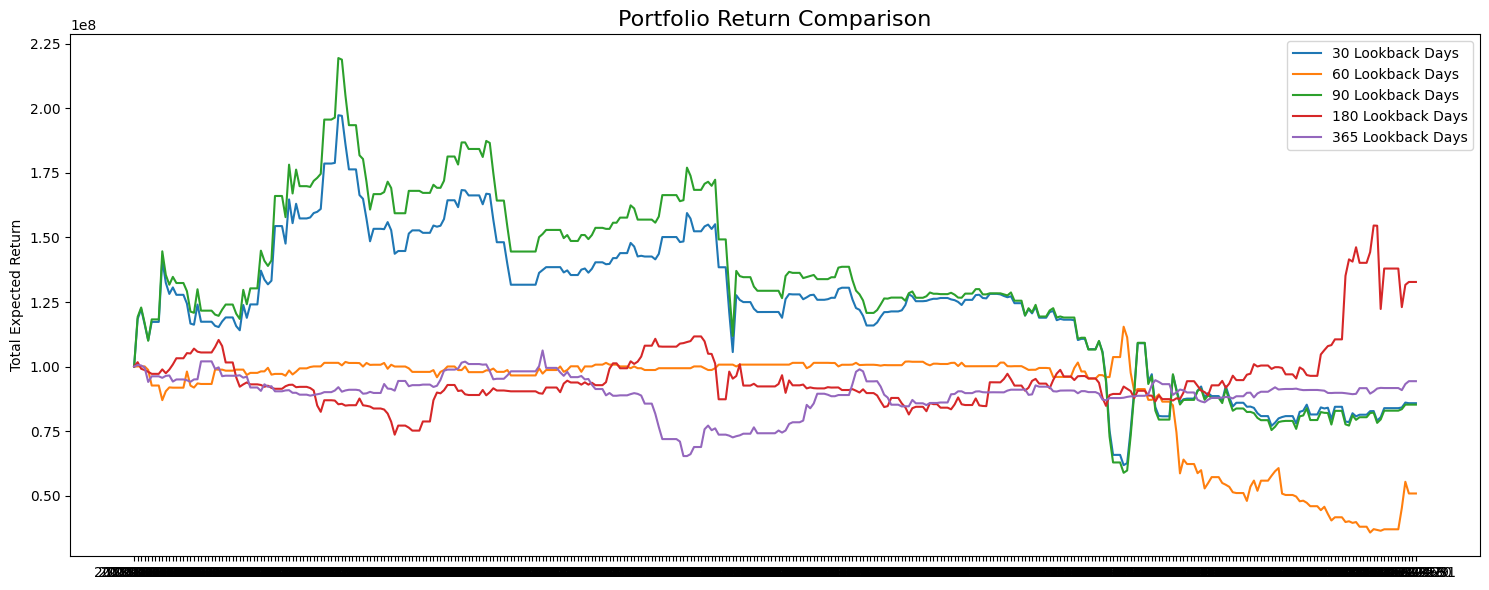

In [42]:
# import matplotlib.dates as mdates

# date_format = mdates.DateFormatter('%Y') 
dataframes = [portfolio_history_30,
              portfolio_history_60,
              portfolio_history_90,
              portfolio_history_180,
             portfolio_history_365]
labels = ["30 Lookback Days",
          "60 Lookback Days",
          "90 Lookback Days",
          "180 Lookback Days",
          "365 Lookback Days"]

plt.figure(figsize=(15, 6))
for df, label in zip(dataframes, labels):
    plt.plot(df['Date'], df['Portfolio Value'], label=label)

# plt.xlabel('Date')
plt.ylabel('Total Expected Return')
plt.title('Portfolio Return Comparison', fontsize=16)
# plt.gca().xaxis.set_major_formatter(date_format)

plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
def calculate_metrics(df_1, df_2, label):
    annualized_return = (df_2['Portfolio Value'].iloc[-1] / df_2['Portfolio Value'].iloc[0] - 1) * 100
    volatility = df_1['portfolio_risk'].iloc[-1]
    drawdown = max(0, (df_2['Portfolio Value'].max() - df_2['Portfolio Value'].min()))

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%",
        'Risk - Volatility': f"{volatility:.2f}%",
        'Drawdown': f"{drawdown:.2f}%",
    }

metrics_list = []
metrics_list.append(calculate_metrics(df_30, portfolio_history_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_60, portfolio_history_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_90, portfolio_history_90, "90 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_180, portfolio_history_180, "180 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_365, portfolio_history_365, "365 Lookback Days Portfolio"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    print(f"  Risk - Volatility: {metrics['Risk - Volatility']}")
    print(f"  Drawdown: {metrics['Drawdown']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: -14.18%
  Risk - Volatility: 20.00%
  Drawdown: 135496935.74%

60 Lookback Days Portfolio:
  Annualized Return: -49.14%
  Risk - Volatility: 6.41%
  Drawdown: 79707070.13%

90 Lookback Days Portfolio:
  Annualized Return: -14.74%
  Risk - Volatility: 9.23%
  Drawdown: 160610793.24%

180 Lookback Days Portfolio:
  Annualized Return: 32.77%
  Risk - Volatility: 4.48%
  Drawdown: 80989406.55%

365 Lookback Days Portfolio:
  Annualized Return: -5.66%
  Risk - Volatility: 3.18%
  Drawdown: 40902262.35%

